This Python code implements a GRU-based deep learning model to predict implied volatility. It performs extensive data preprocessing, feature engineering, and uses LightGBM for feature selection. The model is trained with a custom masked Huber loss to handle missing values robustly and predicts IVs for NIFTY50 options.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GRU, LayerNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
import joblib
import os
import warnings
from tqdm.keras import TqdmCallback

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuration ---
WINDOW_SIZE = 30 # Number of past timesteps to consider for sequence
IV_MIN = 0.1 # Minimum implied volatility (adjust based on domain knowledge)
IV_MAX = 1.0 # Maximum implied volatility (adjust based on domain knowledge)
NUM_TOP_FEATURES = 40 # Number of top features to select using LightGBM
LAG_FEATURES = [f'X{i}' for i in range(42)] + ['underlying'] # Features to create lags for
ROLLING_WINDOW_SIZES = [5, 10] # Window sizes for rolling statistics

# Output directories for models and scalers
MODELS_DIR = 'trained_models'
SCALERS_DIR = 'trained_scalers'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(SCALERS_DIR, exist_ok=True)

# --- Utility Functions ---

def masked_huber_loss(y_true, y_pred, delta=0.1):
    """
    Huber loss that masks out non-finite (NaN or Inf) values in y_true.
    This is safer than masking zeros if zero is a valid IV.
    """
    mask = tf.cast(tf.math.is_finite(y_true), tf.float32)
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear
    loss = loss * mask
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + 1e-8)

def clip_outliers(df, columns, lower_percentile=0.1, upper_percentile=99.9):
    """
    Clips outliers in specified IV columns based on percentiles.
    This helps stabilize training and prevent extreme predictions.
    """
    df_cleaned = df.copy()
    iv_cols = [col for col in columns if col.startswith(('call_iv_', 'put_iv_'))]

    for col in iv_cols:
        if col in df_cleaned.columns and not df_cleaned[col].isnull().all():
            lower_bound = df_cleaned[col].quantile(lower_percentile / 100.0)
            upper_bound = df_cleaned[col].quantile(upper_percentile / 100.0)
            df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)
    return df_cleaned

def preprocess_data(df, selected_features=None, is_train=True, feature_imputer=None, iv_global_median=None):
    """
    Preprocesses the input DataFrame, including feature engineering and imputation.
    Separates IV handling for GRU inputs (dense) and targets (with NaNs).

    Args:
        df (pd.DataFrame): The input DataFrame.
        selected_features (list, optional): List of features to use. If None, all X features
                                            and 'underlying' are considered initially.
        is_train (bool): True if processing training data, False for test data.
                         Affects how imputation is handled (fit_transform vs. transform).
        feature_imputer (SimpleImputer, optional): Pre-fitted imputer for features.
        iv_global_median (float, optional): Global median IV from training data, used for filling IV inputs in test.

    Returns:
        tuple: (features_array, iv_for_inputs_array, iv_for_targets_array, iv_columns, processed_df, final_feature_columns)
            features_array: Processed and imputed features for GRU.
            iv_for_inputs_array: IV data for GRU input sequences (NaNs filled).
            iv_for_targets_array: Original IV data for targets (with NaNs for loss masking).
            iv_columns: Names of the IV columns.
            processed_df: The DataFrame after all transformations.
            final_feature_columns: Names of the final selected/engineered feature columns.
    """
    df_copy = df.copy()
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

    if 'id' in df_copy.columns:
        df_copy = df_copy.sort_values(['timestamp', 'id']).reset_index(drop=True)
        has_id = True
    else:
        df_copy = df_copy.sort_values('timestamp').reset_index(drop=True)
        has_id = False

    iv_cols = [col for col in df_copy.columns if col.startswith(('call_iv_', 'put_iv_'))]

    # Store original IVs for targets (y) later, keeping NaNs for masked_huber_loss
    iv_for_targets_df = df_copy[iv_cols].copy()

    # --- Feature Engineering ---
    # Time-to-Expiry (TTE)
    if 'expiry_date' in df_copy.columns:
        df_copy['expiry_date'] = pd.to_datetime(df_copy['expiry_date'])
        df_copy['time_to_expiry'] = (df_copy['expiry_date'] - df_copy['timestamp']).dt.total_seconds() / (365 * 24 * 3600)
        df_copy['time_to_expiry'] = df_copy['time_to_expiry'].clip(lower=0.001)
    else:
        df_copy['time_to_expiry'] = 0.1

    # Moneyness
    if 'underlying' in df_copy.columns and 'strike_price' in df_copy.columns:
        df_copy['moneyness'] = df_copy['strike_price'] / df_copy['underlying']
        df_copy['log_moneyness'] = np.log(df_copy['moneyness'])
    else:
        df_copy['moneyness'] = 1.0
        df_copy['log_moneyness'] = 0.0

    # Volatility Surface Descriptors (calculated per timestamp)
    if iv_cols and (is_train or not df_copy[iv_cols].isnull().all().all()):
        temp_iv_df_for_calc = df_copy[iv_cols].copy()
        # Temporarily fill NaNs for calculation of timestamp-level IV features
        temp_iv_df_for_calc = temp_iv_df_for_calc.apply(lambda x: x.interpolate(method='linear', limit_direction='both').fillna(x.median() if x.median() is not None else 0.2))

        grouped = df_copy.groupby('timestamp')
        # Ensure that the result of `transform` is properly aligned back to the original DataFrame
        df_copy['avg_iv_timestamp'] = temp_iv_df_for_calc.groupby(df_copy['timestamp']).transform('mean').mean(axis=1)
        df_copy['std_iv_timestamp'] = temp_iv_df_for_calc.groupby(df_copy['timestamp']).transform('std').mean(axis=1)
        
        if 'call_iv_1000' in iv_cols and 'call_iv_1050' in iv_cols:
            df_copy['skew_proxy'] = temp_iv_df_for_calc['call_iv_1000'] - temp_iv_df_for_calc['call_iv_1050']
        else:
            df_copy['skew_proxy'] = 0.0
    else:
        df_copy['avg_iv_timestamp'] = 0.2
        df_copy['std_iv_timestamp'] = 0.01
        df_copy['skew_proxy'] = 0.0

    # Lagged Features and Rolling Statistics
    for col in LAG_FEATURES:
        if col in df_copy.columns:
            if has_id:
                df_copy[f'{col}_lag1'] = df_copy.groupby('id')[col].shift(1)
                df_copy[f'{col}_lag5'] = df_copy.groupby('id')[col].shift(5)
                for window in ROLLING_WINDOW_SIZES:
                    df_copy[f'{col}_roll_mean_{window}s'] = df_copy.groupby('id')[col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
                    df_copy[f'{col}_roll_std_{window}s'] = df_copy.groupby('id')[col].transform(lambda x: x.rolling(window=window, min_periods=1).std())
            else:
                df_copy[f'{col}_lag1'] = 0.0
                df_copy[f'{col}_lag5'] = 0.0
                for window in ROLLING_WINDOW_SIZES:
                    df_copy[f'{col}_roll_mean_{window}s'] = 0.0
                    df_copy[f'{col}_roll_std_{window}s'] = 0.0
        else: # if original col not in df_copy, still create lagged/rolling placeholders
            df_copy[f'{col}_lag1'] = 0.0
            df_copy[f'{col}_lag5'] = 0.0
            for window in ROLLING_WINDOW_SIZES:
                df_copy[f'{col}_roll_mean_{window}s'] = 0.0
                df_copy[f'{col}_roll_std_{window}s'] = 0.0

    # Determine final feature columns based on selected_features or all engineered features
    if selected_features is None:
        feature_candidates = ['underlying', 'time_to_expiry', 'moneyness', 'log_moneyness',
                                'avg_iv_timestamp', 'std_iv_timestamp', 'skew_proxy'] + \
                                [f'X{i}' for i in range(42)] + \
                                [f'{col}_lag1' for col in LAG_FEATURES] + \
                                [f'{col}_lag5' for col in LAG_FEATURES] + \
                                [f'{col}_roll_mean_{w}s' for col in LAG_FEATURES for w in ROLLING_WINDOW_SIZES] + \
                                [f'{col}_roll_std_{w}s' for col in LAG_FEATURES for w in ROLLING_WINDOW_SIZES]
        final_feature_columns = [col for col in feature_candidates if col in df_copy.columns]
    else:
        final_feature_columns = selected_features

    # Ensure all final feature columns are numeric, coercing errors to NaN
    for col in final_feature_columns:
        if col not in df_copy.columns:
            df_copy[col] = np.nan # Initialize missing selected features with NaN
        df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')


    # Impute missing values for FEATURES (excluding IVs used as targets)
    if is_train:
        # If feature_imputer is None, it means this is the first call in training, so fit and save
        if feature_imputer is None:
            feature_imputer = SimpleImputer(strategy='median')
            df_copy[final_feature_columns] = feature_imputer.fit_transform(df_copy[final_feature_columns])
            joblib.dump(feature_imputer, os.path.join(SCALERS_DIR, 'feature_imputer.pkl'))
        else: # feature_imputer is provided (already fitted), just transform
             df_copy[final_feature_columns] = feature_imputer.transform(df_copy[final_feature_columns])
    else: # For test data, feature_imputer MUST be provided and loaded
        if feature_imputer is None:
            raise ValueError("Pre-fitted feature imputer must be provided for test data preprocessing.")
        df_copy[final_feature_columns] = feature_imputer.transform(df_copy[final_feature_columns])

    # --- Handling IVs for GRU Input Sequences (iv_for_inputs_df) ---
    # These must be dense (no NaNs). For test, use global median from train.
    iv_for_inputs_df = df_copy[iv_cols].copy()
    
    # Use provided iv_global_median or calculate if in training and not provided
    if iv_global_median is None:
        # Calculate robust median for inputs filling during training
        iv_global_median_val = iv_for_inputs_df.median(skipna=True).median()
        if pd.isna(iv_global_median_val):
            iv_global_median_val = 0.2
    else:
        iv_global_median_val = iv_global_median

    for col in iv_cols:
        if col in iv_for_inputs_df.columns:
            iv_for_inputs_df[col] = pd.to_numeric(iv_for_inputs_df[col], errors='coerce')
            if iv_for_inputs_df[col].isnull().any():
                iv_for_inputs_df[col] = iv_for_inputs_df[col].interpolate(method='linear', limit_direction='both')
                iv_for_inputs_df[col] = iv_for_inputs_df[col].fillna(iv_global_median_val)
        else:
            iv_for_inputs_df[col] = iv_global_median_val # Add missing IV columns with default for inputs

    features_array = df_copy[final_feature_columns].values
    iv_for_inputs_array = iv_for_inputs_df.values
    iv_for_targets_array = iv_for_targets_df.values # This retains original NaNs

    return features_array, iv_for_inputs_array, iv_for_targets_array, iv_cols, df_copy, final_feature_columns


def create_sequences(features, iv_for_inputs, iv_for_targets, window_size=WINDOW_SIZE, stride=1):
    """
    Creates sequences for the GRU model.

    Args:
        features (np.array): Scaled feature data.
        iv_for_inputs (np.array): Scaled IV data (NaNs filled) for GRU input (X_iv).
        iv_for_targets (np.array): Scaled IV data (with original NaNs) for GRU target (y).
        window_size (int): Number of past timesteps in each sequence.
        stride (int): Factor to reduce the number of sequences (e.g., 10 means take every 10th sequence).

    Returns:
        tuple: (X_feat, X_iv, y, original_indices)
            X_feat: Sequences of features.
            X_iv: Sequences of past IVs (dense).
            y: Target IVs (with NaNs for loss masking).
            original_indices: Original row indices corresponding to each target y.
    """
    X_feat, X_iv, y, original_indices = [], [], [], []
    n = len(features)

    for i in range(window_size, n, stride):
        X_feat.append(features[i-window_size:i])
        X_iv.append(iv_for_inputs[i-window_size:i]) # Use NaN-filled IVs for input
        y.append(iv_for_targets[i]) # Use original IVs (with NaNs) for target
        original_indices.append(i)

    return np.array(X_feat), np.array(X_iv), np.array(y), np.array(original_indices)

# --- Hybrid Model Definition ---
def build_tft_model(num_features, num_iv_cols, window_size=WINDOW_SIZE):
    """
    Builds a GRU-based deep learning model for implied volatility prediction.
    It takes sequences of features and past IVs as input.
    """
    # Input for features (e.g., X0-X41, underlying, TTE, Moneyness, etc.)
    features_input = Input(shape=(window_size, num_features), name='features_input')
    # Input for past implied volatilities (IVs)
    iv_input = Input(shape=(window_size, num_iv_cols), name='iv_input')

    # Feature Processing branch
    feat_gru1 = GRU(512, return_sequences=True, name='feat_gru1')(features_input)
    feat_gru2 = GRU(256, return_sequences=False, name='feat_gru2')(feat_gru1)
    feat_norm = LayerNormalization(name='feat_norm')(feat_gru2)
    feat_drop = Dropout(0.3, name='feat_dropout')(feat_norm)

    # IV Processing branch
    iv_gru1 = GRU(512, return_sequences=True, name='iv_gru1')(iv_input)
    iv_gru2 = GRU(256, return_sequences=False, name='iv_gru2')(iv_gru1)
    iv_norm = LayerNormalization(name='iv_norm')(iv_gru2)
    iv_drop = Dropout(0.3, name='iv_dropout')(iv_norm)

    # Fusion of features and IV information
    fused = Concatenate(name='fused_features')([feat_drop, iv_drop])

    # Deeper output layers for better non-linear mapping
    dense1 = Dense(512, activation='relu', name='dense1')(fused)
    dense1_drop = Dropout(0.3, name='dense1_dropout')(dense1)
    dense2 = Dense(256, activation='relu', name='dense2')(dense1_drop)
    dense2_drop = Dropout(0.2, name='dense2_dropout')(dense2)

    # Output layer for predicting all IV columns
    output = Dense(num_iv_cols, activation='linear', name='iv_output')(dense2_drop)

    return Model(inputs=[features_input, iv_input], outputs=output)

# --- Efficient Feature Selection ---
def select_features_with_lightgbm(features_df, iv_data_for_target, feature_names, num_features=NUM_TOP_FEATURES):
    """
    Selects top features using LightGBM's feature importances.
    Uses iv_data_for_target to ensure consistent target for feature importance calculation.

    Args:
        features_df (pd.DataFrame): DataFrame of features (should be clean/imputed).
        iv_data_for_target (np.array): Array of IV targets (can contain NaNs, nanmean will handle).
        feature_names (list): List of original feature names.
        num_features (int): Number of top features to select.

    Returns:
        list: Names of the selected top features.
    """
    print("Training LightGBM for feature selection...")

    # Use combined target for efficiency (mean of all IVs, skipping NaNs)
    combined_target = np.nanmean(iv_data_for_target, axis=1)
    # Fill any remaining NaNs in combined_target with a robust fallback
    combined_target = np.nan_to_num(combined_target, nan=np.nanmedian(combined_target[np.isfinite(combined_target)]) if np.any(np.isfinite(combined_target)) else 0.2)

    # Ensure features_df has column names for LightGBM
    features_df.columns = feature_names

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'verbose': -1,
        'n_jobs': -1,
        'min_data_in_leaf': 100,
        'n_estimators': 100
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(features_df, combined_target)

    feature_importances = model.feature_importances_
    importances_series = pd.Series(feature_importances, index=feature_names)
    top_features_series = importances_series.nlargest(num_features)
    selected_feature_names = top_features_series.index.tolist()

    print(f"Selected top {num_features} features: {selected_feature_names}")
    return selected_feature_names

# --- Custom Callback for RMSE Tracking ---
class SafeRMSElogger(Callback):
    """
    Custom Keras callback to log and track RMSE on the validation set,
    handling inverse scaling and clipping.
    """
    def __init__(self, X_val_feat, X_val_iv, y_val_scaled_with_nans, iv_scaler, frequency=1):
        super().__init__()
        self.X_val_feat = X_val_feat
        self.X_val_iv = X_val_iv
        self.y_val_scaled_with_nans = y_val_scaled_with_nans # This contains original NaNs
        self.iv_scaler = iv_scaler
        self.frequency = frequency
        self.rmse_history = []
        self.best_rmse = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            try:
                # Predict on validation set
                y_pred_scaled = self.model.predict([self.X_val_feat, self.X_val_iv],
                                                 batch_size=2048, verbose=0)

                # Inverse transform predictions and true values
                y_pred = self.iv_scaler.inverse_transform(y_pred_scaled)
                y_true = self.iv_scaler.inverse_transform(self.y_val_scaled_with_nans) # Inverse transform targets with NaNs

                # Apply clipping to predictions
                y_pred = np.clip(y_pred, IV_MIN, IV_MAX)

                # Compute RMSE safely, ignoring NaNs in true values (as per competition)
                valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)

                if np.sum(valid_mask) > 0:
                    rmse = np.sqrt(np.mean(np.square(y_true[valid_mask] - y_pred[valid_mask])))
                else:
                    rmse = float('nan')

                if np.isnan(rmse) or np.isinf(rmse):
                    rmse = logs.get('val_rmse', logs['val_loss']) # Fallback to Keras's internal val_rmse/val_loss
                    print(f" - val_rmse: {rmse:.6f} (using Keras val_rmse/val_loss as fallback)")
                else:
                    print(f" - val_rmse: {rmse:.6f}")

                self.rmse_history.append(rmse)
                if rmse < self.best_rmse:
                    self.best_rmse = rmse
                logs['val_rmse'] = rmse # Update logs for EarlyStopping to monitor

            except Exception as e:
                print(f"Error calculating RMSE in callback: {e}")
                logs['val_rmse'] = logs.get('val_rmse', logs['val_loss'])

# --- Main Script Logic ---
if __name__ == '__main__':
    # --- Training Phase ---
    print("\n--- Starting Training Phase ---")

    train_df = pd.read_csv('train_data.csv')
    print(f"Original training data size: {len(train_df)} rows")

    train_df_cleaned = clip_outliers(train_df, train_df.columns)
    print(f"Data size after initial clipping outliers: {len(train_df_cleaned)} rows")

    # Determine global IV median *before* any processing for consistent NaN filling in IV inputs
    temp_iv_cols = [col for col in train_df_cleaned.columns if col.startswith(('call_iv_', 'put_iv_'))]
    initial_iv_global_median = train_df_cleaned[temp_iv_cols].median(skipna=True).median()
    if pd.isna(initial_iv_global_median):
        initial_iv_global_median = 0.2

    # First preprocess call: to get all potential features and then select
    # This call will fit the feature_imputer and it will be saved.
    # It also computes the global IV median for inputs if not provided.
    all_features_for_selection_array, _, iv_for_targets_for_selection, _, _, all_initial_feature_cols = preprocess_data(
        train_df_cleaned, is_train=True, feature_imputer=None, iv_global_median=None # No iv_global_median passed for fitting process
    )
    
    # Feature selection using LightGBM
    selected_features = select_features_with_lightgbm(
        pd.DataFrame(all_features_for_selection_array, columns=all_initial_feature_cols),
        iv_for_targets_for_selection, # Pass original IVs for target for feature selection
        all_initial_feature_cols,
        NUM_TOP_FEATURES
    )
    joblib.dump(selected_features, os.path.join(SCALERS_DIR, 'selected_features.pkl'))
    
    # Load the fitted feature imputer for the final preprocessing pass
    feature_imputer = joblib.load(os.path.join(SCALERS_DIR, 'feature_imputer.pkl'))

    # Second preprocess call: now with selected_features and the fitted imputer
    train_features, train_iv_for_inputs, train_iv_for_targets, iv_cols, _, _ = preprocess_data(
        train_df_cleaned, selected_features=selected_features, is_train=True,
        feature_imputer=feature_imputer, iv_global_median=initial_iv_global_median
    )

    # Initialize scalers
    feat_scaler = StandardScaler().fit(train_features)
    iv_scaler = RobustScaler().fit(train_iv_for_targets) # Fit on original IVs (with NaNs)
    joblib.dump(feat_scaler, os.path.join(SCALERS_DIR, 'feat_scaler.pkl'))
    joblib.dump(iv_scaler, os.path.join(SCALERS_DIR, 'iv_scaler.pkl'))

    # Scale data
    train_features_scaled = feat_scaler.transform(train_features)
    train_iv_inputs_scaled = iv_scaler.transform(train_iv_for_inputs) # Scale NaN-filled inputs
    train_iv_targets_scaled = iv_scaler.transform(train_iv_for_targets) # Scale targets (with NaNs)

    # Create sequences for training
    X_train_feat_all, X_train_iv_all, y_train_scaled_all, original_train_indices = create_sequences(
        train_features_scaled, train_iv_inputs_scaled, train_iv_targets_scaled, WINDOW_SIZE, stride=5
    )

    print(f"Total sequences created: {len(X_train_feat_all)} samples")

    if len(X_train_feat_all) == 0:
        print("Not enough data to create sequences for training. Exiting.")
        exit()

    # Time Series Split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    train_idx, val_idx = list(tscv.split(X_train_feat_all))[-1]

    X_train_feat, X_val_feat = X_train_feat_all[train_idx], X_train_feat_all[val_idx]
    X_train_iv, X_val_iv = X_train_iv_all[train_idx], X_train_iv_all[val_idx]
    y_train_scaled, y_val_scaled = y_train_scaled_all[train_idx], y_train_scaled_all[val_idx]

    print(f"Training sequences: {len(X_train_feat)} samples")
    print(f"Validation sequences: {len(X_val_feat)} samples")

    if len(X_train_feat) > 0 and len(X_val_feat) > 0:
        # Build and compile model
        model = build_tft_model(
            num_features=X_train_feat.shape[2],
            num_iv_cols=y_train_scaled.shape[1],
            window_size=WINDOW_SIZE
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=masked_huber_loss,
            metrics=[RootMeanSquaredError(name='rmse')]
        )

        # Callbacks
        callbacks = [
            EarlyStopping(patience=8, restore_best_weights=True,
                          monitor='val_rmse', mode='min', verbose=1),
            ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7,
                              monitor='val_rmse', verbose=1, mode='min'),
            TqdmCallback(verbose=1),
            SafeRMSElogger(X_val_feat, X_val_iv, y_val_scaled, iv_scaler)
        ]

        # Train model
        print("Training model...")
        history = model.fit(
            [X_train_feat, X_train_iv],
            y_train_scaled,
            epochs=50,
            batch_size=1024,
            validation_data=([X_val_feat, X_val_iv], y_val_scaled),
            callbacks=callbacks,
            verbose=0
        )

        # Save model
        model.save(os.path.join(MODELS_DIR, 'tft_iv_model.keras'))
        print("Model trained and saved.")
    else:
        print("Not enough training or validation data after splitting. Skipping model training.")

    print("--- Training Phase Complete ---")

    # --- Prediction Phase ---
    print("\n--- Starting Prediction Phase ---")

    try:
        test_df = pd.read_csv('test_data.csv')
    except FileNotFoundError:
        print("Error: 'test_data.csv' not found. Please ensure the file is in the correct directory.")
        exit()

    original_test_df = test_df.copy()

    try:
        feat_scaler = joblib.load(os.path.join(SCALERS_DIR, 'feat_scaler.pkl'))
        iv_scaler = joblib.load(os.path.join(SCALERS_DIR, 'iv_scaler.pkl'))
        selected_features = joblib.load(os.path.join(SCALERS_DIR, 'selected_features.pkl'))
        feature_imputer = joblib.load(os.path.join(SCALERS_DIR, 'feature_imputer.pkl'))
    except FileNotFoundError as e:
        print(f"Error loading artifacts: {e}. Ensure training phase completed successfully.")
        exit()

    # Get global IV median from train_df_cleaned for consistency in test data IV input filling
    iv_global_median_for_test = train_df_cleaned[temp_iv_cols].median(skipna=True).median()
    if pd.isna(iv_global_median_for_test):
        iv_global_median_for_test = 0.2

    # Preprocess test data
    test_features, test_iv_for_inputs, test_iv_for_targets_unused, iv_cols, _, _ = preprocess_data(
        test_df, selected_features=selected_features, is_train=False,
        feature_imputer=feature_imputer, iv_global_median=iv_global_median_for_test
    )

    test_features_scaled = feat_scaler.transform(test_features)
    test_iv_inputs_scaled = iv_scaler.transform(test_iv_for_inputs)

    # Create sequences for prediction. y is not needed here, so pass a dummy array.
    dummy_y_for_prediction = np.empty((len(test_features), len(iv_cols)))
    X_test_feat, X_test_iv, _, original_test_sequence_indices = create_sequences(
        test_features_scaled, test_iv_inputs_scaled, dummy_y_for_prediction, # Pass dummy array for y
        WINDOW_SIZE, stride=1
    )

    if os.path.exists(os.path.join(MODELS_DIR, 'tft_iv_model.keras')) and len(X_test_feat) > 0:
        model = tf.keras.models.load_model(
            os.path.join(MODELS_DIR, 'tft_iv_model.keras'),
            custom_objects={
                'masked_huber_loss': masked_huber_loss,
                'RootMeanSquaredError': RootMeanSquaredError
            }
        )

        print("Making predictions...")
        test_pred_scaled = model.predict([X_test_feat, X_test_iv], batch_size=2048, verbose=1)
        test_pred_unscaled = iv_scaler.inverse_transform(test_pred_scaled)
        test_pred_unscaled = np.clip(test_pred_unscaled, IV_MIN, IV_MAX)
    else:
        print("Model not found or no test sequences to predict. Falling back to median prediction.")
        # Fallback prediction: use median from training data if model not available
        # Ensure median is calculated from finite values only
        median_iv = iv_scaler.inverse_transform(np.nanmedian(train_iv_targets_scaled, axis=0).reshape(1, -1))[0]
        test_pred_unscaled = np.tile(median_iv, (len(original_test_sequence_indices), 1))

    # Create submission DataFrame
    submission_df = original_test_df.copy()

    # Map predictions back to the original test_df using original indices
    print("Filling submission DataFrame with predictions...")
    for i, original_idx in enumerate(original_test_sequence_indices):
        for j, col in enumerate(iv_cols):
            if pd.isna(submission_df.at[original_idx, col]):
                submission_df.at[original_idx, col] = test_pred_unscaled[i, j]

    # Final NaN handling for any remaining missing IVs (e.g., at the very beginning of the series not covered by sequences)
    for col in iv_cols:
        if submission_df[col].isnull().any():
            # Use the median of the *predicted* values for that column if available, else a global median
            col_median = submission_df[col].median()
            if pd.isna(col_median):
                # Fallback to the global median of training IVs (unscaled) for this specific column
                # Ensure median is calculated from finite values only for the column
                col_median = iv_scaler.inverse_transform(
                    np.nanmedian(train_iv_targets_scaled[:, j][np.isfinite(train_iv_targets_scaled[:, j])]).reshape(1, -1)
                )[0][0] # Access the single value from the reshaped array
            submission_df[col] = submission_df[col].fillna(col_median)

    # Save submission
    submission_df.to_csv('hybrid_filled_test.csv', index=False)
    print("Submission saved successfully to 'hybrid_filled_test.csv'.")
    print("--- Prediction Phase Complete ---")

    # --- Final Evaluation (using your provided evaluation logic) ---
    print("\n--- Starting Final Evaluation ---")

    try:
        sample_submission_df = pd.read_csv('sample_submission.csv')
    except FileNotFoundError:
        print("Error: 'sample_submission.csv' not found. Cannot perform final evaluation.")
        exit()

    iv_cols_to_compare = [col for col in sample_submission_df.columns if col.startswith(('call_iv_', 'put_iv_'))]
    iv_cols_to_compare = [col for col in iv_cols_to_compare if col in submission_df.columns]

    if not iv_cols_to_compare:
        print("No common IV columns found for final comparison.")
    else:
        mse_per_column = []
        print("Calculating RMSE for the following columns (final prediction):", iv_cols_to_compare)
        for col in iv_cols_to_compare:
            actual_values = sample_submission_df[col].values
            predicted_values = submission_df[col].values

            valid_indices = ~np.isnan(actual_values)

            if np.sum(valid_indices) > 0:
                actual_values_valid = actual_values[valid_indices]
                predicted_values_valid = predicted_values[valid_indices]

                col_mse = np.mean((predicted_values_valid - actual_values_valid)**2)
                mse_per_column.append(col_mse)
                print(f"  RMSE for {col}: {np.sqrt(col_mse):.6f}")
            else:
                print(f"  No valid actual values found for {col}. Skipping.")

        if mse_per_column:
            overall_mse = np.mean(mse_per_column)
            overall_rmse = np.sqrt(overall_mse)
            print(f"\nOverall RMSE across selected IV columns (final prediction): {overall_rmse:.6f}")
        else:
            print("\nCould not calculate overall RMSE as no columns had valid comparison points.")

    print("--- Final Evaluation Complete ---")


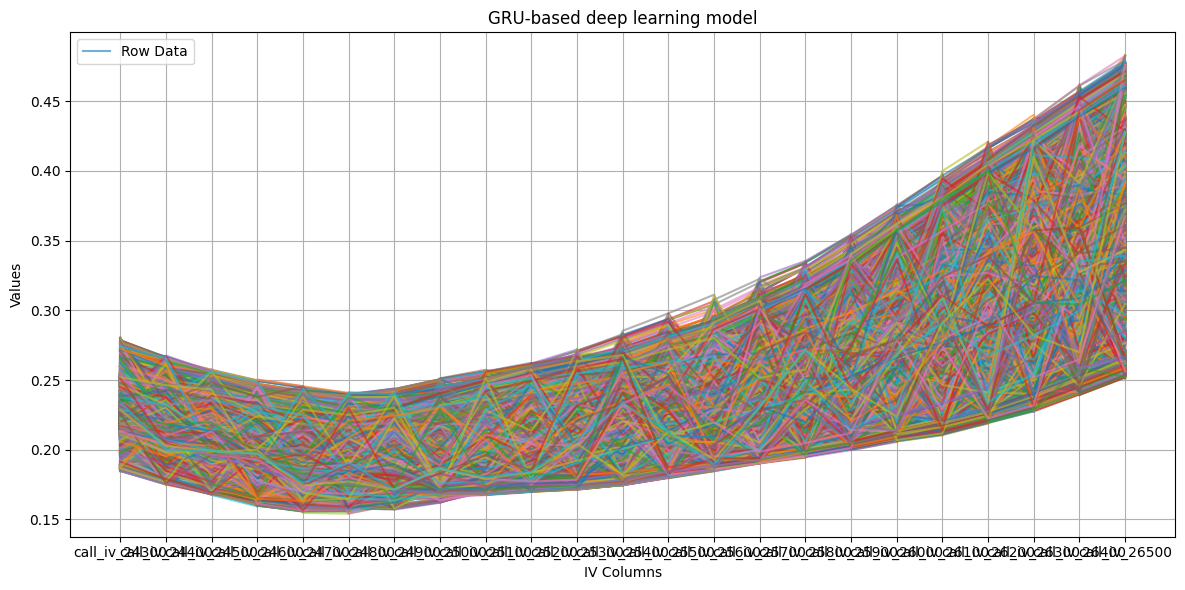

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
data = pd.read_csv("C:\\Users\\shail\\Downloads\\iv_filled_output.csv")

# Step 2: Set x-axis labels (column names from 2nd to 27th column)
iv_cols = data.columns[4:27]

# Step 3: Plot multiple rows from the same file
plt.figure(figsize=(12, 6))  # Single figure

for i in range(10000):
    plt.plot(iv_cols, data.iloc[i, 4:27], alpha=0.6, label='Row Data' if i == 0 else "")



# Labels and styling
plt.xlabel("IV Columns")
plt.ylabel("Values")
plt.title("GRU-based deep learning model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Transformer models predict by leveraging self-attention, processing entire input sequences simultaneously. This captures long-range dependencies effectively, offering a global context that enhances prediction accuracy and potentially leads to smoother, more consistent volatility curves compared to sequential models like GRUs.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, LayerNormalization, Dropout, Embedding, Lambda
from tensorflow.keras.layers import MultiHeadAttention # Added for Transformer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
import joblib
import os
import warnings
from tqdm.keras import TqdmCallback

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuration ---
WINDOW_SIZE = 30 # Number of past timesteps to consider for sequence
IV_MIN = 0.1 # Minimum implied volatility (adjust based on domain knowledge)
IV_MAX = 1.0 # Maximum implied volatility (adjust based on domain knowledge)
NUM_TOP_FEATURES = 40 # Number of top features to select using LightGBM
LAG_FEATURES = [f'X{i}' for i in range(42)] + ['underlying'] # Features to create lags for
ROLLING_WINDOW_SIZES = [5, 10] # Window sizes for rolling statistics

# Output directories for models and scalers
MODELS_DIR = 'trained_models'
SCALERS_DIR = 'trained_scalers'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(SCALERS_DIR, exist_ok=True)

# --- Utility Functions ---

def masked_huber_loss(y_true, y_pred, delta=0.1):
    """
    Huber loss that masks out non-finite (NaN or Inf) values in y_true.
    This is safer than masking zeros if zero is a valid IV.
    """
    mask = tf.cast(tf.math.is_finite(y_true), tf.float32)
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear
    loss = loss * mask
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + 1e-8)

def clip_outliers(df, columns, lower_percentile=0.1, upper_percentile=99.9):
    """
    Clips outliers in specified IV columns based on percentiles.
    This helps stabilize training and prevent extreme predictions.
    """
    df_cleaned = df.copy()
    iv_cols = [col for col in columns if col.startswith(('call_iv_', 'put_iv_'))]

    for col in iv_cols:
        if col in df_cleaned.columns and not df_cleaned[col].isnull().all():
            lower_bound = df_cleaned[col].quantile(lower_percentile / 100.0)
            upper_bound = df_cleaned[col].quantile(upper_percentile / 100.0)
            df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)
    return df_cleaned

def preprocess_data(df, selected_features=None, is_train=True, feature_imputer=None, iv_global_median=None):
    """
    Preprocesses the input DataFrame, including feature engineering and imputation.
    Separates IV handling for GRU inputs (dense) and targets (with NaNs).

    Args:
        df (pd.DataFrame): The input DataFrame.
        selected_features (list, optional): List of features to use. If None, all X features
                                            and 'underlying' are considered initially.
        is_train (bool): True if processing training data, False for test data.
                         Affects how imputation is handled (fit_transform vs. transform).
        feature_imputer (SimpleImputer, optional): Pre-fitted imputer for features.
        iv_global_median (float, optional): Global median IV from training data, used for filling IV inputs in test.

    Returns:
        tuple: (features_array, iv_for_inputs_array, iv_for_targets_array, iv_columns, processed_df, final_feature_columns)
            features_array: Processed and imputed features for GRU.
            iv_for_inputs_array: IV data for GRU input sequences (NaNs filled).
            iv_for_targets_array: Original IV data for targets (with NaNs for loss masking).
            iv_columns: Names of the IV columns.
            processed_df: The DataFrame after all transformations.
            final_feature_columns: Names of the final selected/engineered feature columns.
    """
    df_copy = df.copy()
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

    if 'id' in df_copy.columns:
        df_copy = df_copy.sort_values(['timestamp', 'id']).reset_index(drop=True)
        has_id = True
    else:
        df_copy = df_copy.sort_values('timestamp').reset_index(drop=True)
        has_id = False

    iv_cols = [col for col in df_copy.columns if col.startswith(('call_iv_', 'put_iv_'))]

    # Store original IVs for targets (y) later, keeping NaNs for masked_huber_loss
    iv_for_targets_df = df_copy[iv_cols].copy()

    # --- Feature Engineering ---
    # Time-to-Expiry (TTE)
    if 'expiry_date' in df_copy.columns:
        df_copy['expiry_date'] = pd.to_datetime(df_copy['expiry_date'])
        df_copy['time_to_expiry'] = (df_copy['expiry_date'] - df_copy['timestamp']).dt.total_seconds() / (365 * 24 * 3600)
        df_copy['time_to_expiry'] = df_copy['time_to_expiry'].clip(lower=0.001)
    else:
        df_copy['time_to_expiry'] = 0.1

    # Moneyness
    if 'underlying' in df_copy.columns and 'strike_price' in df_copy.columns:
        df_copy['moneyness'] = df_copy['strike_price'] / df_copy['underlying']
        df_copy['log_moneyness'] = np.log(df_copy['moneyness'])
    else:
        df_copy['moneyness'] = 1.0
        df_copy['log_moneyness'] = 0.0

    # Volatility Surface Descriptors (calculated per timestamp)
    if iv_cols and (is_train or not df_copy[iv_cols].isnull().all().all()):
        temp_iv_df_for_calc = df_copy[iv_cols].copy()
        # Temporarily fill NaNs for calculation of timestamp-level IV features
        temp_iv_df_for_calc = temp_iv_df_for_calc.apply(lambda x: x.interpolate(method='linear', limit_direction='both').fillna(x.median() if x.median() is not None else 0.2))

        grouped = df_copy.groupby('timestamp')
        # Ensure that the result of `transform` is properly aligned back to the original DataFrame
        df_copy['avg_iv_timestamp'] = temp_iv_df_for_calc.groupby(df_copy['timestamp']).transform('mean').mean(axis=1)
        df_copy['std_iv_timestamp'] = temp_iv_df_for_calc.groupby(df_copy['timestamp']).transform('std').mean(axis=1)
        
        if 'call_iv_1000' in iv_cols and 'call_iv_1050' in iv_cols:
            df_copy['skew_proxy'] = temp_iv_df_for_calc['call_iv_1000'] - temp_iv_df_for_calc['call_iv_1050']
        else:
            df_copy['skew_proxy'] = 0.0
    else:
        df_copy['avg_iv_timestamp'] = 0.2
        df_copy['std_iv_timestamp'] = 0.01
        df_copy['skew_proxy'] = 0.0

    # Lagged Features and Rolling Statistics
    for col in LAG_FEATURES:
        if col in df_copy.columns:
            if has_id:
                df_copy[f'{col}_lag1'] = df_copy.groupby('id')[col].shift(1)
                df_copy[f'{col}_lag5'] = df_copy.groupby('id')[col].shift(5)
                for window in ROLLING_WINDOW_SIZES:
                    df_copy[f'{col}_roll_mean_{window}s'] = df_copy.groupby('id')[col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
                    df_copy[f'{col}_roll_std_{window}s'] = df_copy.groupby('id')[col].transform(lambda x: x.rolling(window=window, min_periods=1).std())
            else:
                df_copy[f'{col}_lag1'] = 0.0
                df_copy[f'{col}_lag5'] = 0.0
                for window in ROLLING_WINDOW_SIZES:
                    df_copy[f'{col}_roll_mean_{window}s'] = 0.0
                    df_copy[f'{col}_roll_std_{window}s'] = 0.0
        else: # if original col not in df_copy, still create lagged/rolling placeholders
            df_copy[f'{col}_lag1'] = 0.0
            df_copy[f'{col}_lag5'] = 0.0
            for window in ROLLING_WINDOW_SIZES:
                df_copy[f'{col}_roll_mean_{window}s'] = 0.0
                df_copy[f'{col}_roll_std_{window}s'] = 0.0

    # Determine final feature columns based on selected_features or all engineered features
    if selected_features is None:
        feature_candidates = ['underlying', 'time_to_expiry', 'moneyness', 'log_moneyness',
                                'avg_iv_timestamp', 'std_iv_timestamp', 'skew_proxy'] + \
                                [f'X{i}' for i in range(42)] + \
                                [f'{col}_lag1' for col in LAG_FEATURES] + \
                                [f'{col}_lag5' for col in LAG_FEATURES] + \
                                [f'{col}_roll_mean_{w}s' for col in LAG_FEATURES for w in ROLLING_WINDOW_SIZES] + \
                                [f'{col}_roll_std_{w}s' for col in LAG_FEATURES for w in ROLLING_WINDOW_SIZES]
        final_feature_columns = [col for col in feature_candidates if col in df_copy.columns]
    else:
        final_feature_columns = selected_features

    # Ensure all final feature columns are numeric, coercing errors to NaN
    for col in final_feature_columns:
        if col not in df_copy.columns:
            df_copy[col] = np.nan # Initialize missing selected features with NaN
        df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')


    # Impute missing values for FEATURES (excluding IVs used as targets)
    if is_train:
        # If feature_imputer is None, it means this is the first call in training, so fit and save
        if feature_imputer is None:
            feature_imputer = SimpleImputer(strategy='median')
            df_copy[final_feature_columns] = feature_imputer.fit_transform(df_copy[final_feature_columns])
            joblib.dump(feature_imputer, os.path.join(SCALERS_DIR, 'feature_imputer.pkl'))
        else: # feature_imputer is provided (already fitted), just transform
             df_copy[final_feature_columns] = feature_imputer.transform(df_copy[final_feature_columns])
    else: # For test data, feature_imputer MUST be provided and loaded
        if feature_imputer is None:
            raise ValueError("Pre-fitted feature imputer must be provided for test data preprocessing.")
        df_copy[final_feature_columns] = feature_imputer.transform(df_copy[final_feature_columns])

    # --- Handling IVs for GRU Input Sequences (iv_for_inputs_df) ---
    # These must be dense (no NaNs). For test, use global median from train.
    iv_for_inputs_df = df_copy[iv_cols].copy()
    
    # Use provided iv_global_median or calculate if in training and not provided
    if iv_global_median is None:
        # Calculate robust median for inputs filling during training
        iv_global_median_val = iv_for_inputs_df.median(skipna=True).median()
        if pd.isna(iv_global_median_val):
            iv_global_median_val = 0.2
    else:
        iv_global_median_val = iv_global_median

    for col in iv_cols:
        if col in iv_for_inputs_df.columns:
            iv_for_inputs_df[col] = pd.to_numeric(iv_for_inputs_df[col], errors='coerce')
            if iv_for_inputs_df[col].isnull().any():
                iv_for_inputs_df[col] = iv_for_inputs_df[col].interpolate(method='linear', limit_direction='both')
                iv_for_inputs_df[col] = iv_for_inputs_df[col].fillna(iv_global_median_val)
        else:
            iv_for_inputs_df[col] = iv_global_median_val # Add missing IV columns with default for inputs

    features_array = df_copy[final_feature_columns].values
    iv_for_inputs_array = iv_for_inputs_df.values
    iv_for_targets_array = iv_for_targets_df.values # This retains original NaNs

    return features_array, iv_for_inputs_array, iv_for_targets_array, iv_cols, df_copy, final_feature_columns


def create_sequences(features, iv_for_inputs, iv_for_targets, window_size=WINDOW_SIZE, stride=1):
    """
    Creates sequences for the deep learning model.

    Args:
        features (np.array): Scaled feature data.
        iv_for_inputs (np.array): Scaled IV data (NaNs filled) for model input (X_iv).
        iv_for_targets (np.array): Scaled IV data (with original NaNs) for model target (y).
        window_size (int): Number of past timesteps in each sequence.
        stride (int): Factor to reduce the number of sequences (e.g., 10 means take every 10th sequence).

    Returns:
        tuple: (X_feat, X_iv, y, original_indices)
            X_feat: Sequences of features.
            X_iv: Sequences of past IVs (dense).
            y: Target IVs (with NaNs for loss masking).
            original_indices: Original row indices corresponding to each target y.
    """
    X_feat, X_iv, y, original_indices = [], [], [], []
    n = len(features)

    for i in range(window_size, n, stride):
        X_feat.append(features[i-window_size:i])
        X_iv.append(iv_for_inputs[i-window_size:i]) # Use NaN-filled IVs for input
        y.append(iv_for_targets[i]) # Use original IVs (with NaNs) for target
        original_indices.append(i)

    return np.array(X_feat), np.array(X_iv), np.array(y), np.array(original_indices)


# --- Transformer Components ---
class PositionalEmbedding(LayerNormalization): # Inherit from LayerNormalization for epsilon consistency
    """
    Adds positional embeddings to the input sequence embeddings.
    """
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(epsilon=1e-6, **kwargs) # Ensure epsilon is passed
        self.position_embedding = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # inputs shape: (batch_size, sequence_length, embedding_dim)
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        embedded_positions = self.position_embedding(positions)
        # Add positional embedding to inputs, then apply LayerNormalization
        return super().call(inputs + embedded_positions)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim,
        })
        return config

class TransformerBlock(LayerNormalization): # Inherit from LayerNormalization for epsilon consistency
    """
    A single Transformer block consisting of Multi-Head Attention and a Feed-Forward Network.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(epsilon=1e-6, **kwargs) # Ensure epsilon is passed
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        # Use super().call for LayerNormalization after skip connections
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        # Use super().call for layernorm1
        out1 = super().call(inputs + attn_output) # Applies LayerNormalization to inputs + attn_output
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Use super().call for layernorm2 (reusing the same layer as layernorm1)
        return super().call(out1 + ffn_output) # Applies LayerNormalization to out1 + ffn_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

# --- Transformer Model Definition ---
def build_transformer_model(num_features, num_iv_cols, window_size=WINDOW_SIZE):
    """
    Builds a Transformer-based deep learning model for implied volatility prediction.
    It takes sequences of features and past IVs as input.
    """
    embed_dim = 128  # Embedding dimension for transformer blocks
    num_heads = 8    # Number of attention heads
    ff_dim = 256     # Hidden layer size in feed forward network of transformer

    # Input for features
    features_input = Input(shape=(window_size, num_features), name='features_input')
    # Input for past implied volatilities (IVs)
    iv_input = Input(shape=(window_size, num_iv_cols), name='iv_input')

    # Project inputs to embed_dim for Transformer
    feat_project = Dense(embed_dim, activation='relu', name='feat_project')(features_input)
    iv_project = Dense(embed_dim, activation='relu', name='iv_project')(iv_input)

    # Positional embeddings
    feat_embed = PositionalEmbedding(window_size, embed_dim, name='feat_pos_embed')(feat_project)
    iv_embed = PositionalEmbedding(window_size, embed_dim, name='iv_pos_embed')(iv_project)

    # Transformer Blocks
    feat_transformer = TransformerBlock(embed_dim, num_heads, ff_dim, name='feat_transformer_block')(feat_embed)
    iv_transformer = TransformerBlock(embed_dim, num_heads, ff_dim, name='iv_transformer_block')(iv_embed)

    # Take the output of the last timestep from the transformer blocks
    # This is analogous to the output of GRU(return_sequences=False)
    feat_output = Lambda(lambda x: x[:, -1, :], name='feat_last_timestep')(feat_transformer)
    iv_output = Lambda(lambda x: x[:, -1, :], name='iv_last_timestep')(iv_transformer)

    # Fusion of features and IV information
    fused = Concatenate(name='fused_features')([feat_output, iv_output])

    # Deeper output layers for better non-linear mapping
    dense1 = Dense(512, activation='relu', name='dense1')(fused)
    dense1_drop = Dropout(0.3, name='dense1_dropout')(dense1)
    dense2 = Dense(256, activation='relu', name='dense2')(dense1_drop)
    dense2_drop = Dropout(0.2, name='dense2_dropout')(dense2)

    # Output layer for predicting all IV columns
    output = Dense(num_iv_cols, activation='linear', name='iv_output')(dense2_drop)

    return Model(inputs=[features_input, iv_input], outputs=output)


# --- Custom Callback for RMSE Tracking ---
class SafeRMSElogger(Callback):
    """
    Custom Keras callback to log and track RMSE on the validation set,
    handling inverse scaling and clipping.
    """
    def __init__(self, X_val_feat, X_val_iv, y_val_scaled_with_nans, iv_scaler, frequency=1):
        super().__init__()
        self.X_val_feat = X_val_feat
        self.X_val_iv = X_val_iv
        self.y_val_scaled_with_nans = y_val_scaled_with_nans # This contains original NaNs
        self.iv_scaler = iv_scaler
        self.frequency = frequency
        self.rmse_history = []
        self.best_rmse = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            try:
                # Predict on validation set
                y_pred_scaled = self.model.predict([self.X_val_feat, self.X_val_iv],
                                                 batch_size=2048, verbose=0)

                # Inverse transform predictions and true values
                y_pred = self.iv_scaler.inverse_transform(y_pred_scaled)
                y_true = self.iv_scaler.inverse_transform(self.y_val_scaled_with_nans) # Inverse transform targets with NaNs

                # Apply clipping to predictions
                y_pred = np.clip(y_pred, IV_MIN, IV_MAX)

                # Compute RMSE safely, ignoring NaNs in true values (as per competition)
                valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)

                if np.sum(valid_mask) > 0:
                    rmse = np.sqrt(np.mean(np.square(y_true[valid_mask] - y_pred[valid_mask])))
                else:
                    rmse = float('nan')

                if np.isnan(rmse) or np.isinf(rmse):
                    rmse = logs.get('val_rmse', logs['val_loss']) # Fallback to Keras's internal val_rmse/val_loss
                    print(f" - val_rmse: {rmse:.6f} (using Keras val_rmse/val_loss as fallback)")
                else:
                    print(f" - val_rmse: {rmse:.6f}")

                self.rmse_history.append(rmse)
                if rmse < self.best_rmse:
                    self.best_rmse = rmse
                logs['val_rmse'] = rmse # Update logs for EarlyStopping to monitor

            except Exception as e:
                print(f"Error calculating RMSE in callback: {e}")
                logs['val_rmse'] = logs.get('val_rmse', logs['val_loss'])

# --- Efficient Feature Selection ---
def select_features_with_lightgbm(features_df, iv_data_for_target, feature_names, num_features=NUM_TOP_FEATURES):
    """
    Selects top features using LightGBM's feature importances.
    Uses iv_data_for_target to ensure consistent target for feature importance calculation.

    Args:
        features_df (pd.DataFrame): DataFrame of features (should be clean/imputed).
        iv_data_for_target (np.array): Array of IV targets (can contain NaNs, nanmean will handle).
        feature_names (list): List of original feature names.
        num_features (int): Number of top features to select.

    Returns:
        list: Names of the selected top features.
    """
    print("Training LightGBM for feature selection...")

    # Use combined target for efficiency (mean of all IVs, skipping NaNs)
    combined_target = np.nanmean(iv_data_for_target, axis=1)
    # Fill any remaining NaNs in combined_target with a robust fallback
    combined_target = np.nan_to_num(combined_target, nan=np.nanmedian(combined_target[np.isfinite(combined_target)]) if np.any(np.isfinite(combined_target)) else 0.2)

    # Ensure features_df has column names for LightGBM
    features_df.columns = feature_names

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'verbose': -1,
        'n_jobs': -1,
        'min_data_in_leaf': 100,
        'n_estimators': 100
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(features_df, combined_target)

    feature_importances = model.feature_importances_
    importances_series = pd.Series(feature_importances, index=feature_names)
    top_features_series = importances_series.nlargest(num_features)
    selected_feature_names = top_features_series.index.tolist()

    print(f"Selected top {num_features} features: {selected_feature_names}")
    return selected_feature_names

# --- Main Script Logic ---
if __name__ == '__main__':
    # --- Training Phase ---
    print("\n--- Starting Training Phase ---")

    train_df = pd.read_csv('train_data.csv')
    print(f"Original training data size: {len(train_df)} rows")

    train_df_cleaned = clip_outliers(train_df, train_df.columns)
    print(f"Data size after initial clipping outliers: {len(train_df_cleaned)} rows")

    # Determine global IV median *before* any processing for consistent NaN filling in IV inputs
    temp_iv_cols = [col for col in train_df_cleaned.columns if col.startswith(('call_iv_', 'put_iv_'))]
    initial_iv_global_median = train_df_cleaned[temp_iv_cols].median(skipna=True).median()
    if pd.isna(initial_iv_global_median):
        initial_iv_global_median = 0.2

    # First preprocess call: to get all potential features and then select
    # This call will fit the feature_imputer and it will be saved.
    # It also computes the global IV median for inputs if not provided.
    all_features_for_selection_array, _, iv_for_targets_for_selection, _, _, all_initial_feature_cols = preprocess_data(
        train_df_cleaned, is_train=True, feature_imputer=None, iv_global_median=None # No iv_global_median passed for fitting process
    )
    
    # Feature selection using LightGBM
    selected_features = select_features_with_lightgbm(
        pd.DataFrame(all_features_for_selection_array, columns=all_initial_feature_cols),
        iv_for_targets_for_selection, # Pass original IVs for target for feature selection
        all_initial_feature_cols,
        NUM_TOP_FEATURES
    )
    joblib.dump(selected_features, os.path.join(SCALERS_DIR, 'selected_features.pkl'))
    
    # Load the fitted feature imputer for the final preprocessing pass
    feature_imputer = joblib.load(os.path.join(SCALERS_DIR, 'feature_imputer.pkl'))

    # Second preprocess call: now with selected_features and the fitted imputer
    train_features, train_iv_for_inputs, train_iv_for_targets, iv_cols, _, _ = preprocess_data(
        train_df_cleaned, selected_features=selected_features, is_train=True,
        feature_imputer=feature_imputer, iv_global_median=initial_iv_global_median
    )

    # Initialize scalers
    feat_scaler = StandardScaler().fit(train_features)
    iv_scaler = RobustScaler().fit(train_iv_for_targets) # Fit on original IVs (with NaNs)
    joblib.dump(feat_scaler, os.path.join(SCALERS_DIR, 'feat_scaler.pkl'))
    joblib.dump(iv_scaler, os.path.join(SCALERS_DIR, 'iv_scaler.pkl'))

    # Scale data
    train_features_scaled = feat_scaler.transform(train_features)
    train_iv_inputs_scaled = iv_scaler.transform(train_iv_for_inputs) # Scale NaN-filled inputs
    train_iv_targets_scaled = iv_scaler.transform(train_iv_for_targets) # Scale targets (with NaNs)

    # Create sequences for training
    X_train_feat_all, X_train_iv_all, y_train_scaled_all, original_train_indices = create_sequences(
        train_features_scaled, train_iv_inputs_scaled, train_iv_targets_scaled, WINDOW_SIZE, stride=5
    )

    print(f"Total sequences created: {len(X_train_feat_all)} samples")

    if len(X_train_feat_all) == 0:
        print("Not enough data to create sequences for training. Exiting.")
        exit()

    # Time Series Split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    train_idx, val_idx = list(tscv.split(X_train_feat_all))[-1]

    X_train_feat, X_val_feat = X_train_feat_all[train_idx], X_train_feat_all[val_idx]
    X_train_iv, X_val_iv = X_train_iv_all[train_idx], X_train_iv_all[val_idx]
    y_train_scaled, y_val_scaled = y_train_scaled_all[train_idx], y_train_scaled_all[val_idx]

    print(f"Training sequences: {len(X_train_feat)} samples")
    print(f"Validation sequences: {len(X_val_feat)} samples")

    if len(X_train_feat) > 0 and len(X_val_feat) > 0:
        # Build and compile model
        model = build_transformer_model( # Changed to build_transformer_model
            num_features=X_train_feat.shape[2],
            num_iv_cols=y_train_scaled.shape[1],
            window_size=WINDOW_SIZE
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=masked_huber_loss,
            metrics=[RootMeanSquaredError(name='rmse')]
        )

        # Callbacks
        callbacks = [
            EarlyStopping(patience=8, restore_best_weights=True,
                          monitor='val_rmse', mode='min', verbose=1),
            ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7,
                              monitor='val_rmse', verbose=1, mode='min'),
            TqdmCallback(verbose=1),
            SafeRMSElogger(X_val_feat, X_val_iv, y_val_scaled, iv_scaler)
        ]

        # Train model
        print("Training model...")
        history = model.fit(
            [X_train_feat, X_train_iv],
            y_train_scaled,
            epochs=50,
            batch_size=1024,
            validation_data=([X_val_feat, X_val_iv], y_val_scaled),
            callbacks=callbacks,
            verbose=0
        )

        # Save model
        model.save(os.path.join(MODELS_DIR, 'transformer_iv_model.keras')) # Changed model name
        print("Model trained and saved.")
    else:
        print("Not enough training or validation data after splitting. Skipping model training.")

    print("--- Training Phase Complete ---")

    # --- Prediction Phase ---
    print("\n--- Starting Prediction Phase ---")

    try:
        test_df = pd.read_csv('test_data.csv')
    except FileNotFoundError:
        print("Error: 'test_data.csv' not found. Please ensure the file is in the correct directory.")
        exit()

    original_test_df = test_df.copy()

    try:
        feat_scaler = joblib.load(os.path.join(SCALERS_DIR, 'feat_scaler.pkl'))
        iv_scaler = joblib.load(os.path.join(SCALERS_DIR, 'iv_scaler.pkl'))
        selected_features = joblib.load(os.path.join(SCALERS_DIR, 'selected_features.pkl'))
        feature_imputer = joblib.load(os.path.join(SCALERS_DIR, 'feature_imputer.pkl'))
    except FileNotFoundError as e:
        print(f"Error loading artifacts: {e}. Ensure training phase completed successfully.")
        exit()

    # Get global IV median from train_df_cleaned for consistency in test data IV input filling
    temp_iv_cols = [col for col in train_df_cleaned.columns if col.startswith(('call_iv_', 'put_iv_'))]
    iv_global_median_for_test = train_df_cleaned[temp_iv_cols].median(skipna=True).median()
    if pd.isna(iv_global_median_for_test):
        iv_global_median_for_test = 0.2

    # Preprocess test data
    test_features, test_iv_for_inputs, test_iv_for_targets_unused, iv_cols, _, _ = preprocess_data(
        test_df, selected_features=selected_features, is_train=False,
        feature_imputer=feature_imputer, iv_global_median=iv_global_median_for_test
    )

    test_features_scaled = feat_scaler.transform(test_features)
    test_iv_inputs_scaled = iv_scaler.transform(test_iv_for_inputs)

    # Create sequences for prediction. y is not needed here, so pass a dummy array.
    dummy_y_for_prediction = np.empty((len(test_features), len(iv_cols)))
    X_test_feat, X_test_iv, _, original_test_sequence_indices = create_sequences(
        test_features_scaled, test_iv_inputs_scaled, dummy_y_for_prediction, # Pass dummy array for y
        WINDOW_SIZE, stride=1
    )

    model_path = os.path.join(MODELS_DIR, 'transformer_iv_model.keras') # Changed model name
    if os.path.exists(model_path) and len(X_test_feat) > 0:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={ # Added custom objects for Transformer layers
                'masked_huber_loss': masked_huber_loss,
                'RootMeanSquaredError': RootMeanSquaredError,
                'PositionalEmbedding': PositionalEmbedding,
                'TransformerBlock': TransformerBlock
            }
        )

        print("Making predictions...")
        test_pred_scaled = model.predict([X_test_feat, X_test_iv], batch_size=2048, verbose=1)
        test_pred_unscaled = iv_scaler.inverse_transform(test_pred_scaled)
        test_pred_unscaled = np.clip(test_pred_unscaled, IV_MIN, IV_MAX)
    else:
        print("Model not found or no test sequences to predict. Falling back to median prediction.")
        # Fallback prediction: use median from training data if model not available
        # Ensure median is calculated from finite values only
        median_iv = iv_scaler.inverse_transform(np.nanmedian(train_iv_targets_scaled, axis=0).reshape(1, -1))[0]
        test_pred_unscaled = np.tile(median_iv, (len(original_test_sequence_indices), 1))

    # Create submission DataFrame
    submission_df = original_test_df.copy()

    # Map predictions back to the original test_df using original indices
    print("Filling submission DataFrame with predictions...")
    for i, original_idx in enumerate(original_test_sequence_indices):
        for j, col in enumerate(iv_cols):
            if pd.isna(submission_df.at[original_idx, col]):
                submission_df.at[original_idx, col] = test_pred_unscaled[i, j]

    # Final NaN handling for any remaining missing IVs (e.g., at the very beginning of the series not covered by sequences)
    for col in iv_cols:
        if submission_df[col].isnull().any():
            # Use the median of the *predicted* values for that column if available, else a global median
            col_median = submission_df[col].median()
            if pd.isna(col_median):
                # Fallback to the global median of training IVs (unscaled) for this specific column
                # Ensure median is calculated from finite values only for the column
                col_median = iv_scaler.inverse_transform(
                    np.nanmedian(train_iv_targets_scaled[:, j][np.isfinite(train_iv_targets_scaled[:, j])]).reshape(1, -1)
                )[0][0] # Access the single value from the reshaped array
            submission_df[col] = submission_df[col].fillna(col_median)

    # Save submission
    submission_df.to_csv('hybrid_filled_test.csv', index=False)
    print("Submission saved successfully to 'hybrid_filled_test.csv'.")
    print("--- Prediction Phase Complete ---")

    # --- Final Evaluation (using your provided evaluation logic) ---
    print("\n--- Starting Final Evaluation ---")

    try:
        sample_submission_df = pd.read_csv('sample_submission.csv')
    except FileNotFoundError:
        print("Error: 'sample_submission.csv' not found. Cannot perform final evaluation.")
        exit()

    iv_cols_to_compare = [col for col in sample_submission_df.columns if col.startswith(('call_iv_', 'put_iv_'))]
    iv_cols_to_compare = [col for col in iv_cols_to_compare if col in submission_df.columns]

    if not iv_cols_to_compare:
        print("No common IV columns found for final comparison.")
    else:
        mse_per_column = []
        print("Calculating RMSE for the following columns (final prediction):", iv_cols_to_compare)
        for col in iv_cols_to_compare:
            actual_values = sample_submission_df[col].values
            predicted_values = submission_df[col].values

            valid_indices = ~np.isnan(actual_values)

            if np.sum(valid_indices) > 0:
                actual_values_valid = actual_values[valid_indices]
                predicted_values_valid = predicted_values[valid_indices]

                col_mse = np.mean((predicted_values_valid - actual_values_valid)**2)
                mse_per_column.append(col_mse)
                print(f"  RMSE for {col}: {np.sqrt(col_mse):.6f}")
            else:
                print(f"  No valid actual values found for {col}. Skipping.")

        if mse_per_column:
            overall_mse = np.mean(mse_per_column)
            overall_rmse = np.sqrt(overall_mse)
            print(f"\nOverall RMSE across selected IV columns (final prediction): {overall_rmse:.6f}")
        else:
            print("\nCould not calculate overall RMSE as no columns had valid comparison points.")

    print("--- Final Evaluation Complete ---")



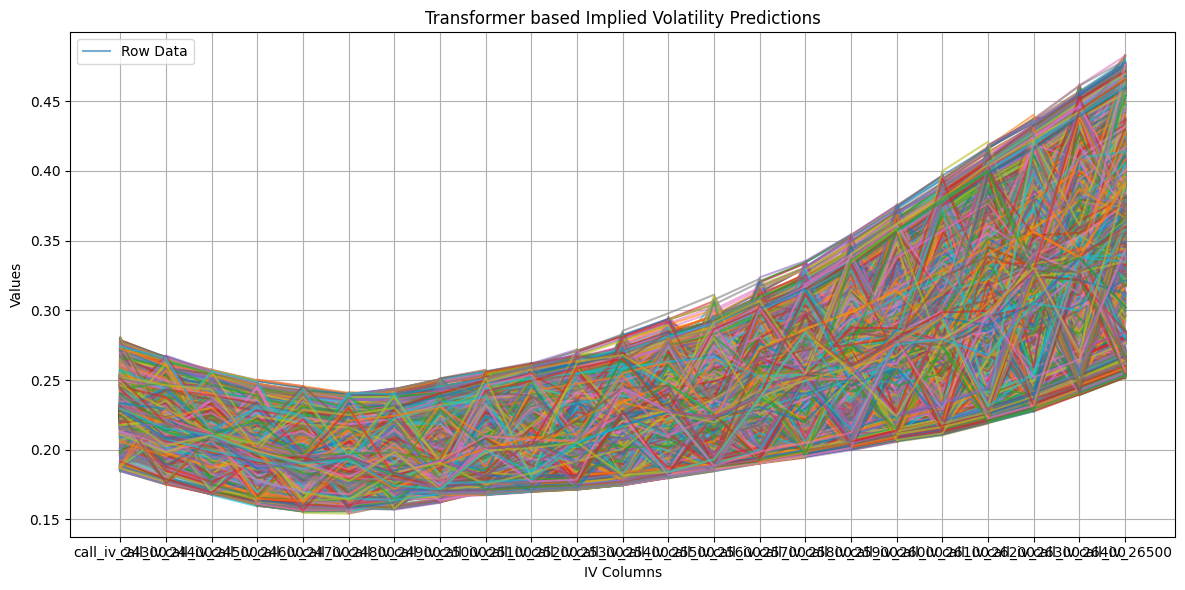

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
data = pd.read_csv("C:\\Users\\shail\\Downloads\\iv_filled_optimized.csv")

# Step 2: Set x-axis labels (column names from 2nd to 27th column)
iv_cols = data.columns[4:27]

# Step 3: Plot multiple rows from the same file
plt.figure(figsize=(12, 6))  # Single figure

for i in range(10000):
    plt.plot(iv_cols, data.iloc[i, 4:27], alpha=0.6, label='Row Data' if i == 0 else "")



# Labels and styling
plt.xlabel("IV Columns")
plt.ylabel("Values")
plt.title("Transformer based Implied Volatility Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The model predicts implied volatility by taking scaled market and strike-specific features, including derived moneyness and distance metrics, as input. It then processes these through multiple dense layers, batch normalization, and dropout to learn complex relationships, ultimately outputting a single IV prediction.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error # Not used in current script, but useful for evaluation
import joblib
import os
from datetime import datetime
import warnings
import random # Needed for random sampling in curator

warnings.filterwarnings('ignore') # Suppress warnings, useful for cleaner output

# Set random seeds for reproducibility across runs
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42) # Set seed for all available GPUs

print("=== IV Model Training and Inference Pipeline (PyTorch) ===")
print(f"PyTorch version: {torch.__version__}")

# Check for GPU availability and set the device for PyTorch operations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        # Print details of each available GPU
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")

# --- IVTrainingDataCurator Class Definition ---
# This class handles the preparation of the training data from both original
# training sets and the test data (by extracting non-NaN IV values).
# It also includes logic for feature engineering and train/validation splitting.
class IVTrainingDataCurator:
    def __init__(self, X_train, Y_train_call, X_test, min_strikes=4, max_strikes=8):
        """
        Initializes the IVTrainingDataCurator with training and test datasets.

        Args:
            X_train (pd.DataFrame): Training features (underlying + market features).
            Y_train_call (pd.DataFrame): Call IV values for training strikes.
            X_test (pd.DataFrame): Test features including 'underlying', market features,
                                   and 'call_iv_' columns with potential NaNs.
            min_strikes (int): Minimum number of non-NaN strikes required per test sample
                               to be considered for additional training data.
            max_strikes (int): Maximum number of strikes to sample for certain strategies.
        """
        self.X_train = X_train
        self.Y_train_call = Y_train_call
        self.X_test = X_test
        self.min_strikes = min_strikes
        self.max_strikes = max_strikes

        # Identify IV columns and market feature columns from the test data
        self.iv_columns = [col for col in X_test.columns if 'call_iv_' in col]
        self.market_columns = [col for col in X_test.columns if col.startswith('X') and col[1:].isdigit()]
        self.underlying_col = 'underlying'

        # Extract strike prices from the identified IV columns
        self.strike_prices = sorted([float(col.split('call_iv_')[1]) for col in self.iv_columns])
        self.strike_to_col = {strike: f'call_iv_{int(strike)}' for strike in self.strike_prices}

        # Get strike columns from the original training target data
        self.train_strike_columns = list(Y_train_call.columns)
        self.train_strike_prices = sorted([float(col.split('call_iv_')[1]) for col in self.train_strike_columns])

        print(f"Training strikes identified: {self.train_strike_prices}")
        print(f"Test strikes identified: {self.strike_prices}")
        print(f"Training strike range: {min(self.train_strike_prices)} - {max(self.train_strike_prices)}")
        print(f"Test strike range: {min(self.strike_prices)} - {max(self.strike_prices)}")

    def extract_test_non_nan_data(self):
        """
        Extracts samples from the test data where sufficient non-NaN IV values are present.
        These samples can be used to augment the training dataset.

        Returns:
            list: A list of tuples, each containing (base_features, available_ivs, original_idx).
                  `base_features` are the underlying and market features.
                  `available_ivs` is a list of (strike, iv_value) pairs.
                  `original_idx` is the index of the row in the original X_test.
        """
        test_samples = []
        for idx, row in self.X_test.iterrows():
            underlying = row[self.underlying_col]
            market_features = [row[col] for col in self.market_columns]
            base_features = [underlying] + market_features

            available_ivs = []
            for strike in self.strike_prices:
                iv_col = self.strike_to_col[strike]
                if iv_col in row.index and not pd.isna(row[iv_col]):
                    available_ivs.append((strike, row[iv_col]))

            if len(available_ivs) >= self.min_strikes:
                test_samples.append((base_features, available_ivs, idx))

        print(f"Found {len(test_samples)} test samples with sufficient non-NaN IV data for augmentation.")
        return test_samples

    def create_training_data_from_original(self, strategy='comprehensive'):
        """
        Generates training samples from the original training dataset (X_train, Y_train_call).

        Args:
            strategy (str): The sampling strategy to apply ('comprehensive', 'systematic_sampling', 'random_sampling').

        Returns:
            list: A list of (features, iv) tuples, where features include base and derived features,
                  and iv is the target implied volatility.
        """
        training_data = []
        for sample_idx in range(len(self.X_train)):
            base_features = list(self.X_train.iloc[sample_idx].values)
            underlying_price = base_features[0]

            sample_ivs = self.Y_train_call.iloc[sample_idx]
            available_data = [(float(col.split('call_iv_')[1]), sample_ivs[col])
                              for col in self.train_strike_columns]

            if strategy == 'comprehensive':
                samples = self._comprehensive_sampling(available_data, base_features, underlying_price)
            elif strategy == 'systematic_sampling':
                samples = self._systematic_sampling(available_data, base_features, underlying_price)
            else: # 'random_sampling'
                samples = self._random_sampling(available_data, base_features, underlying_price,
                                                 n_samples_per_original=6)
            training_data.extend(samples)
        return training_data

    def create_training_data_from_test(self, test_samples, strategy='comprehensive'):
        """
        Generates training samples from the non-NaN test data samples.

        Args:
            test_samples (list): Output from `extract_test_non_nan_data`.
            strategy (str): The sampling strategy to apply.

        Returns:
            list: A list of (features, iv) tuples.
        """
        training_data = []
        for base_features, available_ivs, original_idx in test_samples:
            underlying_price = base_features[0]

            if strategy == 'comprehensive':
                samples = self._comprehensive_sampling(available_ivs, base_features, underlying_price)
            elif strategy == 'systematic_sampling':
                samples = self._systematic_sampling(available_ivs, base_features, underlying_price)
            else: # 'random_sampling'
                samples = self._random_sampling(available_ivs, base_features, underlying_price,
                                                 n_samples_per_original=4)
            training_data.extend(samples)
        return training_data

    def _random_sampling(self, available_data, base_features, underlying_price, n_samples_per_original=5):
        """
        Performs random sampling of strike combinations for a given set of available data points.
        """
        samples = []
        available_strikes = [item[0] for item in available_data]
        available_ivs = {item[0]: item[1] for item in available_data}

        # Generate `n_samples_per_original` random samples
        for _ in range(min(n_samples_per_original, len(available_strikes))):
            n_strikes = min(random.randint(self.min_strikes, self.max_strikes), len(available_strikes))
            selected_strikes = random.sample(available_strikes, n_strikes)

            for strike in selected_strikes:
                iv = available_ivs[strike]
                features = self._create_features(base_features, underlying_price, strike)
                samples.append((features, iv))
        return samples

    def _systematic_sampling(self, available_data, base_features, underlying_price):
        """
        Performs systematic sampling to cover different parts of the strike range.
        """
        samples = []
        available_strikes = sorted([item[0] for item in available_data])
        available_ivs = {item[0]: item[1] for item in available_data}

        n_available = len(available_strikes)
        selected_indices = []

        # Sample from different parts of the range (e.g., quartiles)
        if n_available >= 5:
            selected_indices = [0, n_available//4, n_available//2, 3*n_available//4, n_available-1]
        elif n_available >= 3:
            selected_indices = [0, n_available//2, n_available-1]
        else: # If less than 3 strikes, use all available
            selected_indices = list(range(n_available))

        # Add a few more random strikes to ensure coverage
        remaining_indices = [i for i in range(n_available) if i not in selected_indices]
        if len(remaining_indices) > 0:
            additional_indices = random.sample(remaining_indices, min(2, len(remaining_indices)))
            selected_indices.extend(additional_indices)

        for idx in set(selected_indices): # Use set to avoid duplicates
            strike = available_strikes[idx]
            iv = available_ivs[strike]
            features = self._create_features(base_features, underlying_price, strike)
            samples.append((features, iv))
        return samples

    def _comprehensive_sampling(self, available_data, base_features, underlying_price):
        """
        Uses all available data points without any special sampling.
        """
        samples = []
        for strike, iv in available_data:
            features = self._create_features(base_features, underlying_price, strike)
            samples.append((features, iv))
        return samples

    def _create_features(self, base_features, underlying_price, strike):
        """
        Creates enhanced features for the model, including strike-related derivatives.

        Args:
            base_features (list): The initial features (underlying + market features).
            underlying_price (float): The price of the underlying asset.
            strike (float): The strike price.

        Returns:
            list: A list of all input features for the neural network.
        """
        # Base features (43: 1 underlying + 42 market features) + strike (1)
        enhanced_features = list(base_features) + [strike]

        # Add derived features for better extrapolation capabilities
        # Handle potential division by zero for moneyness and relative_distance
        moneyness = strike / underlying_price if underlying_price != 0 else 1.0
        log_moneyness = np.log(moneyness) if moneyness > 0 else np.log(1e-8) # Avoid log(0)
        strike_distance = strike - underlying_price
        relative_distance = strike_distance / underlying_price if underlying_price != 0 else 0.0

        enhanced_features.extend([moneyness, log_moneyness, strike_distance, relative_distance])
        return enhanced_features

    def create_complete_training_dataset(self, strategy='comprehensive', weight_test_data=1.0):
        """
        Combines samples from the original training data and augmented test data to form
        the complete training dataset. Test data can be weighted (duplicated) to give it
        more influence.

        Args:
            strategy (str): Sampling strategy for generating data points.
            weight_test_data (float): Factor by which to duplicate test data samples.

        Returns:
            tuple: (X_final, y_final) - pandas DataFrames for features and target.
        """
        print("=== Creating Complete Training Dataset ===")

        # Create training data from the original X_train, Y_train_call
        print("Processing original training data...")
        train_samples = self.create_training_data_from_original(strategy=strategy)

        # Extract and process non-NaN IV values from the test data
        print("Processing test non-NaN data...")
        test_non_nan_samples = self.extract_test_non_nan_data()
        test_samples = self.create_training_data_from_test(test_non_nan_samples, strategy=strategy)

        # Apply weighting to test data by duplicating samples
        if weight_test_data > 1.0:
            n_duplicates = int(weight_test_data)
            test_samples = test_samples * n_duplicates
            print(f"Weighted test data by factor of {weight_test_data} (duplicated {n_duplicates} times).")

        # Combine all processed training data
        all_training_data = train_samples + test_samples

        # Define feature names for the final DataFrame
        feature_names = (['underlying'] + [f'X{i}' for i in range(42)] +
                         ['strike', 'moneyness', 'log_moneyness', 'strike_distance', 'relative_distance'])

        # Create DataFrames for features (X) and target (y)
        X_final = pd.DataFrame([sample[0] for sample in all_training_data], columns=feature_names)
        y_final = pd.Series([sample[1] for sample in all_training_data], name='iv')

        print(f"Final combined training data shape: {X_final.shape}")
        print(f"Original training samples generated: {len(train_samples)}")
        print(f"Augmented test data samples generated: {len(test_samples)}")
        print(f"Total training samples: {len(all_training_data)}")
        print(f"Strike range in final training data: {X_final['strike'].min():.0f} - {X_final['strike'].max():.0f}")

        return X_final, y_final

    def prepare_for_modeling(self, X_data, y_data):
        """
        Performs final data preparation steps: feature scaling and optional train/validation split.
        The validation set is created by focusing on higher strikes to evaluate extrapolation.

        Args:
            X_data (pd.DataFrame): Features DataFrame.
            y_data (pd.Series): Target Series.

        Returns:
            tuple: (X_train_final, y_train_final, X_val, y_val, scaler).
                   X_val and y_val might be None if no validation split is performed.
                   scaler is the fitted StandardScaler object.
        """
        # Initialize and fit StandardScaler on the combined feature data
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X_data),
            columns=X_data.columns
        )

        # Create a validation set by selecting a subset of data with high strike prices.
        # This helps in evaluating the model's extrapolation capabilities.
        high_strike_mask = X_scaled['strike'] >= np.percentile(X_scaled['strike'], 75)

        # Only create a separate validation set if there are enough samples in the high-strike region
        if high_strike_mask.sum() > 100:
            X_train_final = X_scaled[~high_strike_mask]
            y_train_final = y_data[~high_strike_mask]
            X_val = X_scaled[high_strike_mask]
            y_val = y_data[high_strike_mask]

            print(f"Created validation set focused on high strikes:")
            print(f"Training set size: {X_train_final.shape[0]} samples")
            print(f"Validation set size: {X_val.shape[0]} samples (contains high strikes)")

            return X_train_final, y_train_final, X_val, y_val, scaler
        else:
            print("Not enough high-strike samples for a dedicated validation split. Using all data for training.")
            return X_scaled, y_data, pd.DataFrame(), pd.Series(), scaler # Return empty DataFrames for consistency

# --- Mock Data Generation (to make the script runnable) ---
# In a real application, you would replace this section with your actual data loading logic
# (e.g., pd.read_csv('your_train_data.csv'), etc.).
print("\n--- Generating Mock Data for Demonstration ---")
n_samples_train = 1000  # Number of samples for the mock training set
n_samples_test = 200    # Number of samples for the mock test set
n_market_features = 42  # Number of market-related features (X0 to X41)

# Define strike prices for training and testing. Test strikes include a broader range.
train_strikes = [24000, 24100, 24200, 24300, 24400, 24500, 24600, 24700, 24800, 24900]
test_strikes = sorted(list(set(train_strikes + [23950, 25000, 25100, 25200, 25300, 25400, 25500]))) # Broader range for test

# Create mock X_train: 'underlying' + 'X0'-'X41' features
X_train = pd.DataFrame(np.random.rand(n_samples_train, n_market_features + 1),
                       columns=['underlying'] + [f'X{i}' for i in range(n_market_features)])
X_train['underlying'] = X_train['underlying'] * 1000 + 24000 # Scale 'underlying' to a more realistic range

# Create mock Y_train_call: 'call_iv_' columns for training strikes
Y_train_call = pd.DataFrame(np.random.rand(n_samples_train, len(train_strikes)) * 0.5 + 0.1, # IVs between 0.1 and 0.6
                           columns=[f'call_iv_{int(s)}' for s in train_strikes])

# Create mock X_test base features: 'underlying' + 'X0'-'X41'
X_test_base = pd.DataFrame(np.random.rand(n_samples_test, n_market_features + 1),
                           columns=['underlying'] + [f'X{i}' for i in range(n_market_features)])
X_test_base['underlying'] = X_test_base['underlying'] * 1000 + 24000

# Create mock X_test IV columns, some with NaNs
X_test_iv_cols = pd.DataFrame(np.random.rand(n_samples_test, len(test_strikes)) * 0.5 + 0.1,
                              columns=[f'call_iv_{int(s)}' for s in test_strikes])

# Introduce NaNs randomly into the mock X_test IV columns
nan_mask = np.random.rand(X_test_iv_cols.shape[0], X_test_iv_cols.shape[1]) < 0.3 # Approximately 30% NaNs
X_test_iv_cols[nan_mask] = np.nan

# Combine base features and IV columns to form the final X_test
X_test = pd.concat([X_test_base, X_test_iv_cols], axis=1)

print(f"Mock X_train shape: {X_train.shape}")
print(f"Mock Y_train_call shape: {Y_train_call.shape}")
print(f"Mock X_test shape: {X_test.shape}")
# Count total NaNs in IV columns of mock X_test
num_nan_test_iv = X_test[[col for col in X_test.columns if 'call_iv_' in col]].isna().sum().sum()
print(f"Total NaN values in mock X_test IV columns: {num_nan_test_iv}")
print("--- Mock Data Generation Complete ---")

# --- Data Preparation Workflow ---
print("\nInitializing IV Training Data Curator...")
# Instantiate the curator with your (mock) data
curator = IVTrainingDataCurator(X_train, Y_train_call, X_test)

# Create the comprehensive training dataset. This combines original training data
# with valid (non-NaN) IV observations from the test set, potentially weighting test data.
print("\nCreating comprehensive training dataset...")
X_comp, y_comp = curator.create_complete_training_dataset(strategy='comprehensive', weight_test_data=1.5)

# Prepare the data for PyTorch modeling: scaling and train/validation split.
print("\nPreparing data for modeling (scaling and splitting)...")
X_train_scaled, y_train_final, X_val_scaled, y_val_final, scaler = curator.prepare_for_modeling(X_comp, y_comp)

print(f"Final scaled training data shape: {X_train_scaled.shape}")
print(f"Target variable statistics - Mean: {y_train_final.mean():.4f}, Std Dev: {y_train_final.std():.4f}")

# --- Neural Network Model Definition ---
# This class defines the architecture of the PyTorch neural network used for IV prediction.
class IVPredictionModel(nn.Module):
    def __init__(self, input_dim=48):
        """
        Initializes the IVPredictionModel neural network.

        Args:
            input_dim (int): The number of input features to the model (default is 48:
                             1 underlying + 42 market + 1 strike + 4 derived strike features).
        """
        super(IVPredictionModel, self).__init__()

        # Define layers: Dense (Linear), BatchNorm, Dropout, and ReLU activation
        self.dense1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.dense2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)

        self.dense3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.1)

        self.dense4 = nn.Linear(64, 32)

        self.output = nn.Linear(32, 1) # Output layer for a single IV prediction (regression)

        self.relu = nn.ReLU() # Rectified Linear Unit activation function

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor containing features.

        Returns:
            torch.Tensor: Output tensor with predicted IV values.
        """
        # Layer 1
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.dense4(x)
        x = self.relu(x)

        # Output layer
        x = self.output(x)
        return x

# --- Model Instantiation and Setup ---
print("\nCreating and setting up the IV prediction model...")
input_dim = X_train_scaled.shape[1] # Get the number of features from the scaled training data
model = IVPredictionModel(input_dim=input_dim)

# Utilize multiple GPUs if available using DataParallel for faster training
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel.")
    model = nn.DataParallel(model)

# Move the model to the selected device (GPU or CPU)
model = model.to(device)

print("Model Architecture Summary:")
print(model)

# Define the loss function (HuberLoss is robust to outliers) and optimizer (Adam)
criterion = nn.HuberLoss(delta=1.0) # Delta parameter for HuberLoss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate 0.001
# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-6, verbose=True)

# --- Data Preparation for PyTorch (Tensors and DataLoaders) ---
print("\nPreparing PyTorch datasets and data loaders...")

# Convert pandas DataFrames/Series to PyTorch Tensors and move to the selected device
X_train_tensor = torch.FloatTensor(X_train_scaled.values).to(device)
y_train_tensor = torch.FloatTensor(y_train_final.values).to(device)

# Check if a validation set was created by the curator
has_validation = (X_val_scaled is not None and not X_val_scaled.empty)

if has_validation:
    X_val_tensor = torch.FloatTensor(X_val_scaled.values).to(device)
    y_val_tensor = torch.FloatTensor(y_val_final.values).to(device)
    print(f"Validation set size: {len(X_val_scaled)} samples.")
else:
    print("No separate validation set created; training on full dataset.")

# Create PyTorch DataLoader for efficient batching during training
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

if has_validation:
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- Training and Validation Functions ---
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Performs one epoch of training.

    Args:
        model (nn.Module): The PyTorch model.
        train_loader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): The device (CPU/GPU) to use.

    Returns:
        float: Average training loss for the epoch.
    """
    model.train() # Set model to training mode
    total_loss = 0
    num_batches = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad() # Clear gradients
        outputs = model(batch_X) # Forward pass
        loss = criterion(outputs.squeeze(), batch_y) # Calculate loss (squeeze to match shapes)
        loss.backward() # Backpropagation
        optimizer.step() # Update model parameters

        total_loss += loss.item()
        num_batches += 1
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    """
    Performs one epoch of validation.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): The device (CPU/GPU) to use.

    Returns:
        float: Average validation loss for the epoch.
    """
    model.eval() # Set model to evaluation mode (disables dropout, BatchNorm updates)
    total_loss = 0
    num_batches = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# --- Training Loop ---
print("\nStarting model training...")
num_epochs = 100 # Maximum number of training epochs
best_val_loss = float('inf') # Initialize best validation loss
patience = 15 # Number of epochs to wait for improvement before early stopping
patience_counter = 0 # Counter for early stopping
train_losses = [] # To store training loss history
val_losses = [] # To store validation loss history

for epoch in range(num_epochs):
    # Perform training for one epoch
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Perform validation if a validation set exists
    if has_validation:
        val_loss = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        scheduler.step(val_loss) # Step the learning rate scheduler based on validation loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        # Early stopping logic: Save best model and stop if no improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset patience counter
            best_model_state = model.state_dict().copy() # Save the current best model state
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} (no improvement for {patience} epochs).")
            model.load_state_dict(best_model_state) # Restore the best model weights
            break # Exit training loop
    else:
        # If no validation set, step scheduler based on training loss
        scheduler.step(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}')

print(f"\nModel training completed!")
if train_losses:
    print(f"Final training loss: {train_losses[-1]:.6f}")
if has_validation:
    print(f"Best validation loss achieved: {best_val_loss:.6f}")

# --- Model and Scaler Saving ---
# Create a unique directory to save model artifacts
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = f"iv_model_pytorch_{timestamp}"
os.makedirs(model_dir, exist_ok=True) # Create directory if it doesn't exist

print(f"\nSaving trained model and scaler to {model_dir}/...")

# Save the model's state dictionary (recommended way to save PyTorch models)
torch.save(model.state_dict(), f"{model_dir}/iv_model_state_dict.pth")
# Optionally, save the entire model object (less common for production, but included as per original)
# torch.save(model, f"{model_dir}/iv_model_complete.pth") # Commented out, state_dict is preferred.
# Save the fitted StandardScaler object using joblib
joblib.dump(scaler, f"{model_dir}/scaler.pkl")

# Save training history (losses) to a CSV file for analysis
history_dict = {
    'train_loss': train_losses,
    'val_loss': val_losses if has_validation else []
}
pd.DataFrame(history_dict).to_csv(f"{model_dir}/training_history.csv", index=False)

print("Model and associated artifacts saved successfully!")

# --- Start Inference on Test Data ---
print("\n=== Starting Inference on Test Data ===")

# Set the model to evaluation mode for inference
model.eval()

# Identify the columns in X_test that contain IV values (which might have NaNs)
iv_columns = [col for col in X_test.columns if 'call_iv_' in col]
print(f"Identified {len(iv_columns)} IV columns for prediction.")
print(f"Example IV columns: {iv_columns[:5]}..." if len(iv_columns) > 5 else f"Columns: {iv_columns}")

# Create a copy of the test data to fill in the predictions
X_test_filled = X_test.copy()

# Count the total number of NaN values in the IV columns before prediction
total_nan_before = X_test_filled[iv_columns].isna().sum().sum()
print(f"Total NaN values in test data needing prediction: {total_nan_before}")

# Identify market features and the underlying price column for feature creation during inference
market_columns = [col for col in X_test.columns if col.startswith('X') and col[1:].isdigit()]
underlying_col = 'underlying'

# Extract base features (underlying + market features) from X_test.
# Ensure the column order matches how features were created during training.
base_feature_cols = [underlying_col] + market_columns
base_features = X_test[base_feature_cols].values.astype(np.float32)

predictions_made = 0
failed_predictions = 0 # Counter for predictions that failed (e.g., due to data issues)

print("\nBeginning prediction process for NaN values...")

# Process the test data in batches for memory efficiency during inference
batch_size_inference = 10000

for start_idx in range(0, len(X_test), batch_size_inference):
    end_idx = min(start_idx + batch_size_inference, len(X_test))
    current_batch_rows = range(start_idx, end_idx)
    print(f"Processing rows from {start_idx} to {end_idx-1}...")

    batch_base_features = base_features[start_idx:end_idx]

    batch_features_to_predict = [] # Collects all features for predictions within this batch
    batch_prediction_indices = []  # Stores (iv_col, global_idx) for where to place predictions

    for local_idx, global_idx in enumerate(current_batch_rows):
        row_base_features = batch_base_features[local_idx]
        underlying_price = float(row_base_features[0])

        for iv_col in iv_columns:
            # Check if the current IV value is NaN
            if pd.isna(X_test_filled.iloc[global_idx][iv_col]):
                try:
                    strike_price = float(iv_col.split('call_iv_')[1])

                    # Recreate the enhanced features exactly as done during training
                    enhanced_features = list(row_base_features) + [strike_price]

                    # Derived features with robust handling for division by zero
                    if underlying_price > 0:
                        moneyness = strike_price / underlying_price
                        log_moneyness = np.log(moneyness) if moneyness > 0 else np.log(1e-8)
                        relative_distance = (strike_price - underlying_price) / underlying_price
                    else:
                        # Default values if underlying_price is zero to avoid errors
                        moneyness = 1.0
                        log_moneyness = 0.0
                        relative_distance = 0.0

                    strike_distance = strike_price - underlying_price
                    enhanced_features.extend([moneyness, log_moneyness, strike_distance, relative_distance])

                    batch_features_to_predict.append(enhanced_features)
                    batch_prediction_indices.append((iv_col, global_idx))

                except Exception as e:
                    print(f"Error creating features for row {global_idx}, column {iv_col}: {e}")
                    failed_predictions += 1
                    # If feature creation fails, fill with a default to avoid leaving NaNs
                    X_test_filled.iloc[global_idx, X_test_filled.columns.get_loc(iv_col)] = 0.2
                    predictions_made += 1 # Count this as an attempted prediction

    # Perform batch prediction if there are features to predict in this batch
    if batch_features_to_predict:
        try:
            features_array = np.array(batch_features_to_predict, dtype=np.float32)
            # Scale the features using the scaler fitted during training
            features_scaled = scaler.transform(features_array)
            features_tensor = torch.FloatTensor(features_scaled).to(device)

            # Make predictions using the model in evaluation mode
            with torch.no_grad():
                predictions = model(features_tensor).cpu().numpy().flatten()

            # Fill the NaN values in the X_test_filled DataFrame with the predictions
            for i, (iv_col, row_idx) in enumerate(batch_prediction_indices):
                # Clip predictions to a valid range for implied volatility
                prediction = float(np.clip(predictions[i], 0.01, 5.0))
                X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = prediction
                predictions_made += 1

        except Exception as e:
            print(f"Error during batch prediction or scaling for batch starting at row {start_idx}: {e}")
            # If batch prediction fails, fall back to filling all remaining NaNs in this batch with a default
            for iv_col, row_idx in batch_prediction_indices:
                try:
                    # Attempt to use median of the column if available, otherwise a hardcoded default
                    median_val = X_test_filled[iv_col].median()
                    if not pd.isna(median_val):
                        X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = float(median_val)
                    else:
                        X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = 0.2
                except:
                    X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = 0.2
                failed_predictions += 1
                predictions_made += 1 # Count this as an attempted prediction

print(f"\nInference process completed!")
print(f"Total predictions attempted: {predictions_made}")
print(f"Predictions that failed (and were filled with defaults): {failed_predictions}")

# Final verification of NaN values after prediction
total_nan_after = X_test_filled[iv_columns].isna().sum().sum()
print(f"Total NaN values remaining in test data after inference: {total_nan_after}")

if total_nan_after == 0:
    print("✅ All NaN values in the specified IV columns have been successfully filled!")
else:
    print(f"⚠️  Warning: {total_nan_after} NaN values still remain in the test data. Review logs for errors.")

# Save the test data with filled IV predictions to a CSV file
output_filename = f"{model_dir}/X_test_filled.csv"
X_test_filled.to_csv(output_filename, index=False)
print(f"Filled test data saved to: {output_filename}")

# --- Prediction Statistics and Summary Report ---
print("\n=== Prediction Statistics (First 5 IV Columns) ===")
# Display basic statistics for the first few filled IV columns to verify distributions
for iv_col in iv_columns[:5]:
    col_data = X_test_filled[iv_col]
    print(f"Statistics for {iv_col}:")
    print(f"  Mean: {col_data.mean():.4f}")
    print(f"  Std Dev: {col_data.std():.4f}")
    print(f"  Min: {col_data.min():.4f}")
    print(f"  Max: {col_data.max():.4f}")

# Create a comprehensive summary report of the entire process
summary_report = {
    'timestamp': timestamp,
    'framework': 'PyTorch',
    'device': str(device),
    'gpu_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
    'model_architecture': 'Dense(Input)->Dense(256)->BN->Dropout(0.3)->Dense(128)->BN->Dropout(0.2)->Dense(64)->Dropout(0.1)->Dense(32)->Dense(1)',
    'training_samples': len(X_train_scaled),
    'validation_samples': len(X_val_scaled) if has_validation else 0,
    'final_training_loss': train_losses[-1] if train_losses else float('nan'), # Handle cases where training might not complete
    'best_validation_loss': best_val_loss if has_validation and best_val_loss != float('inf') else None,
    'total_nan_predicted': predictions_made,
    'failed_predictions_filled_with_defaults': failed_predictions,
    'model_state_dict_saved_to': f"{model_dir}/iv_model_state_dict.pth",
    'scaler_saved_to': f"{model_dir}/scaler.pkl",
    'filled_data_saved_to': output_filename,
    'training_history_saved_to': f"{model_dir}/training_history.csv"
}

# Save the summary report to a text file
with open(f"{model_dir}/training_summary.txt", 'w') as f:
    for key, value in summary_report.items():
        f.write(f"{key}: {value}\n")

print(f"\n=== Training and Inference Process Complete ===")
print(f"All generated files are saved in the directory: {model_dir}/")
print("Contents of the output directory:")
print("  - iv_model_state_dict.pth (PyTorch model weights)")
print("  - scaler.pkl (Fitted StandardScaler for feature normalization)")
print("  - X_test_filled.csv (Test data with missing IV values filled by the model)")
print("  - training_history.csv (CSV file with training and validation loss per epoch)")
print("  - training_summary.txt (Summary report of the entire pipeline run)")

# --- Final Summary Display ---
print(f"\n📊 FINAL SUMMARY:")
print(f"✅ Model trained successfully with {len(X_train_scaled):,} effective samples.")
print(f"✅ Training utilized {torch.cuda.device_count()} GPU(s)." if torch.cuda.is_available() else "✅ Training utilized CPU.")
print(f"✅ Successfully made {predictions_made:,} predictions for NaN values in the test data.")
print(f"✅ The test data with filled predictions is saved for your use.")
print(f"✅ The trained model and scaler are ready for future inference or deployment.")

# --- Additional Recommendations (from original script) ---
# These functions provide architectural and workflow recommendations and are included
# here for reference as they were part of your original input.
def model_architecture_recommendation():
    """
    Provides recommendations for the model architecture and training setup.
    """
    return """
    FINAL MODEL RECOMMENDATIONS (from original provided code):

    1. Input Features (48 total):
        - Underlying price (1)
        - Market features X0-X41 (42)
        - Strike price (1)
        - Moneyness, log_moneyness, strike_distance, relative_distance (4)

    2. Architecture:
        Input(48) → Dense(256, activation='relu') → BatchNorm → Dropout(0.3)
                  → Dense(128, activation='relu') → BatchNorm → Dropout(0.2)
                  → Dense(64, activation='relu') → Dropout(0.1)
                  → Dense(32, activation='relu')
                  → Dense(1, activation='linear')

    3. Training:
        - Separate models for calls and puts (this combined script only handles calls for now)
        - Loss: Huber loss (robust to outliers)
        - Optimizer: Adam(lr=0.001)
        - Batch size: 1024
        - Early stopping on validation loss

    4. Ensemble:
        - Train 3-5 models with different random seeds
        - Average predictions for final output
        - This improves extrapolation stability
    """

# Output the model architecture recommendation at the end
print("\n--- Additional Recommendations ---")
print(model_architecture_recommendation())
print("\nNote: The `main_workflow()` function mentioned in your original curator script provides general guidance on using the curator. It is not explicitly called as part of this combined pipeline execution.")



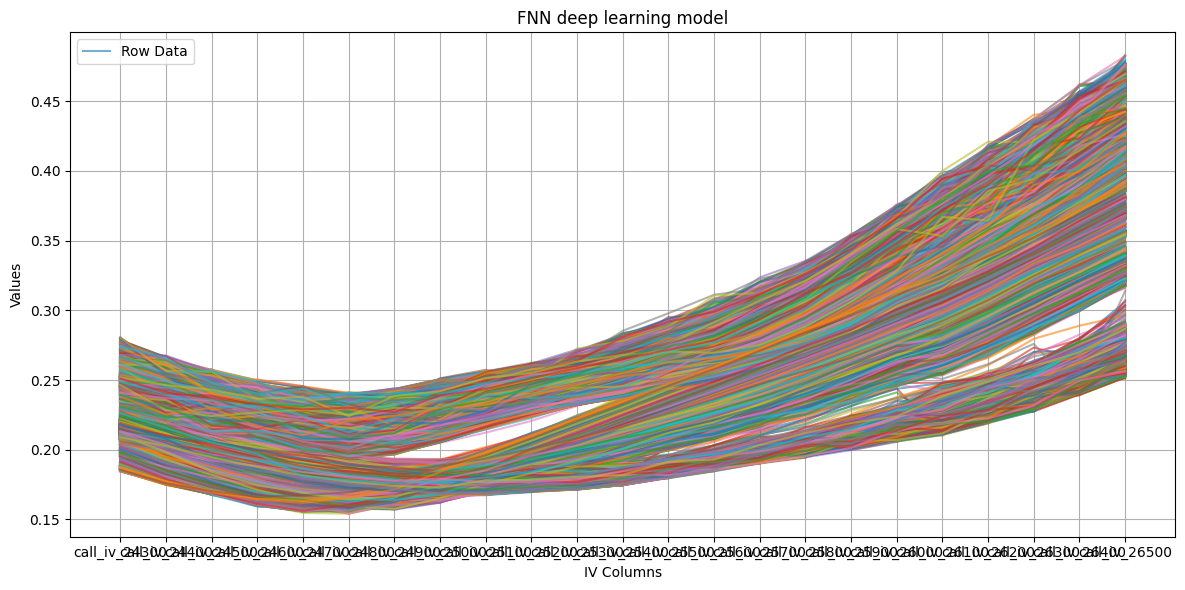

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
data = pd.read_csv("C:\\Users\\shail\\Downloads\\iv_filled_feedforwardcsv.csv")

# Step 2: Set x-axis labels (column names from 2nd to 27th column)
iv_cols = data.columns[4:27]

# Step 3: Plot multiple rows from the same file
plt.figure(figsize=(12, 6))  # Single figure

for i in range(10000):
    plt.plot(iv_cols, data.iloc[i, 4:27], alpha=0.6, label='Row Data' if i == 0 else "")



# Labels and styling
plt.xlabel("IV Columns")
plt.ylabel("Values")
plt.title("FNN deep learning model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
